In [18]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [19]:
import sys
print(sys.executable)


C:\Users\Wildanamru\anaconda3\envs\tensorflow-py\python.exe


In [20]:
import os
import shutil
from sklearn.model_selection import train_test_split

train_dir = "bisindo/images/train"
test_dir = "bisindo/images/test"

os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    # pastikan ini folder
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    # split 15% per kelas
    train_imgs, test_imgs = train_test_split(
        images,
        test_size=0.15,
        random_state=42
    )

    # buat folder kelas di test
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # pindahkan gambar test
    for img in test_imgs:
        shutil.move(
            os.path.join(class_path, img),
            os.path.join(test_dir, class_name, img)
        )

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
# kalau pakai VGG19:
# from tensorflow.keras.applications.vgg19 import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ===============================
# DATAGEN KHUSUS VGG
# ===============================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ===============================
# GENERATOR
# ===============================
train_gen = train_datagen.flow_from_directory(
    "bisindo/images/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    "bisindo/images/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    "bisindo/images/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # penting untuk evaluasi
)

Found 4747 images belonging to 26 classes.
Found 2301 images belonging to 26 classes.
Found 4422 images belonging to 26 classes.


In [22]:
num_classes = train_gen.num_classes  # harus 26
class_names = list(train_gen.class_indices.keys())
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [23]:
import os
import json

class_indices = train_gen.class_indices
print(class_indices)

# pastikan folder ada
os.makedirs("../modelling", exist_ok=True)

with open("../modelling/label_vgg.json", "w") as f:
    json.dump(class_indices, f)


{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [24]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D
)
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=base_model.input, outputs=output)

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
history = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)

Epoch 1/15
149/149 [==============================] - 59s 389ms/step - loss: 6.4183 - accuracy: 0.0683 - val_loss: 3.0710 - val_accuracy: 0.2299
Epoch 2/15
149/149 [==============================] - 57s 384ms/step - loss: 3.4562 - accuracy: 0.1843 - val_loss: 2.4335 - val_accuracy: 0.3998
Epoch 3/15
149/149 [==============================] - 57s 381ms/step - loss: 2.6706 - accuracy: 0.3044 - val_loss: 2.0461 - val_accuracy: 0.5454
Epoch 4/15
149/149 [==============================] - 58s 389ms/step - loss: 2.2442 - accuracy: 0.4043 - val_loss: 1.7240 - val_accuracy: 0.6306
Epoch 5/15
149/149 [==============================] - 59s 396ms/step - loss: 1.8942 - accuracy: 0.4963 - val_loss: 1.4636 - val_accuracy: 0.7001
Epoch 6/15
149/149 [==============================] - 112s 752ms/step - loss: 1.6581 - accuracy: 0.5570 - val_loss: 1.2691 - val_accuracy: 0.7397
Epoch 7/15
149/149 [==============================] - 111s 747ms/step - loss: 1.4834 - accuracy: 0.5989 - val_loss: 1.1263 - val_

In [27]:
import numpy as np
from sklearn.metrics import classification_report

y_pred_vgg = np.argmax(vgg_model.predict(test_gen), axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print("=== Classification Report VGG ===")
print(classification_report(
    y_true,
    y_pred_vgg,
    target_names=class_names
))

139/139 [==============================] - 73s 527ms/step
=== Classification Report VGG ===
              precision    recall  f1-score   support

           A       0.93      0.83      0.88       169
           B       0.91      0.83      0.87       169
           C       0.79      0.75      0.77       166
           D       0.81      0.79      0.80       168
           E       0.87      0.82      0.84       170
           F       0.85      0.86      0.85       172
           G       0.75      0.92      0.83       173
           H       0.76      0.82      0.79       168
           I       0.75      0.82      0.78       173
           J       0.81      0.86      0.83       173
           K       0.95      0.77      0.85       168
           L       0.77      0.80      0.78       172
           M       0.81      0.83      0.82       172
           N       0.85      0.85      0.85       169
           O       0.98      0.97      0.97       172
           P       0.88      0.73      0.80

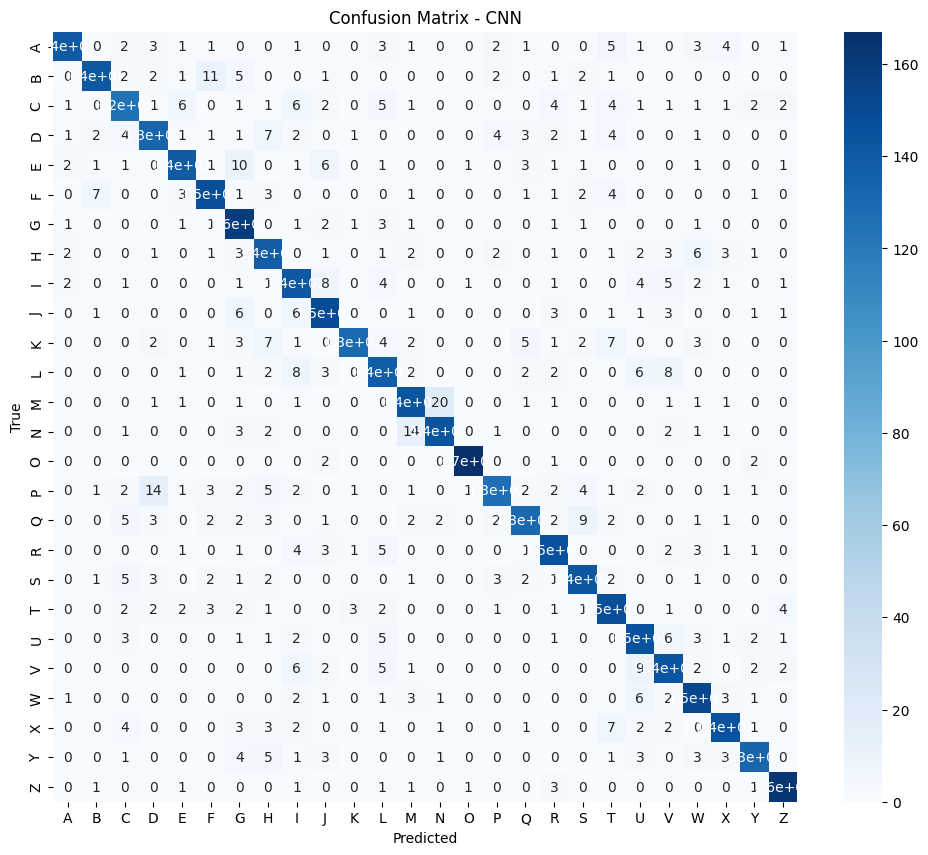

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_vgg)

plt.figure(figsize=(12,10))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    annot=True
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.show()


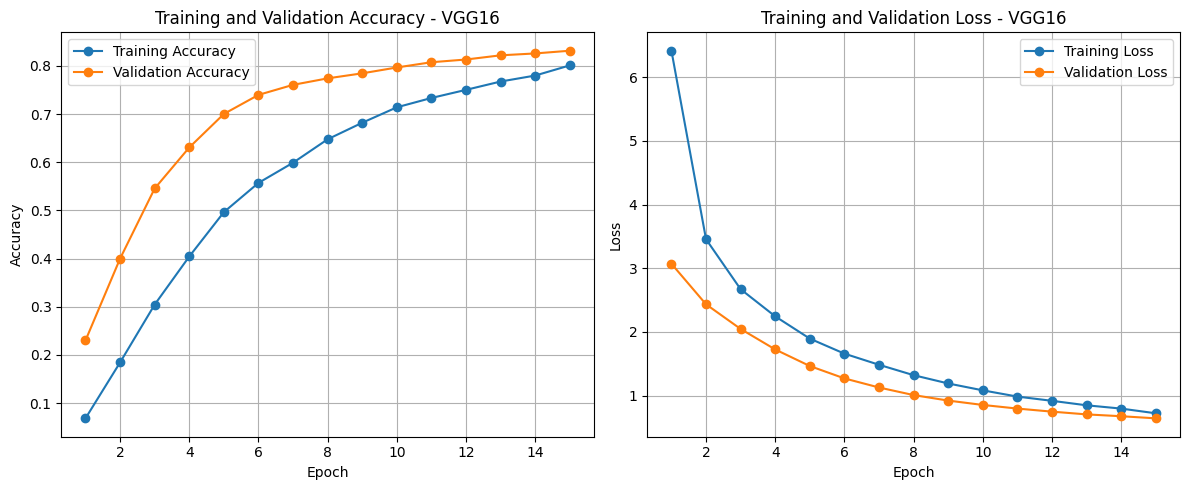

In [31]:
import matplotlib.pyplot as plt

# ===============================
# Ambil data dari history VGG
# ===============================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# ===============================
# Grafik Accuracy
# ===============================
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ===============================
# Grafik Loss
# ===============================
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, marker='o', label='Training Loss')
plt.plot(epochs, val_loss, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss - VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
vgg_model.save("../modelling/vgg_model.h5")